# General Idea for the project

The project is aimed to solve the following problem: given a review (or any piece of text), classify it as positive or negative. Since it was mostly trained using amazon product reviews, it was tested on those same types of text: product reviews.  

This problem is solved using a <b>RNN</b> (Recursive Neural Network), which is a type of neural network that is able to take into account the previous information that it was given. In this particular problem, sentiment analysis, it is important to take into account the previous words in order to understand the context of the sentence. For example, the sentence "I love this product" is positive, but "I don't love this product" is negative.

# Imports and dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Masking
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from gensim.models import KeyedVectors, Word2Vec
from nltk.tokenize import word_tokenize

2023-07-31 18:09:36.706594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 18:09:37.429855: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Global variables
sample_size = 30000

tf.random.set_seed(42)
np.random.seed(42)

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pedranji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/pedranji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
df = pd.read_csv('/home/pedranji/Projects/RNNs/Datasets/amazonreviews.csv')

# Data visualization
I want to see the distribution of the scores of the reviews to see if my dataset is imbalanced.

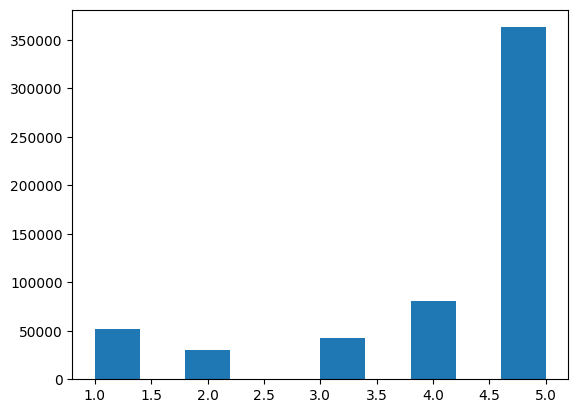

In [6]:
plt.hist(df["Score"])
plt.show()

In view of the distribution of the dataset, I will downsample the dataset to make it a bit more balanced.   

I will reduce the amount of 5-star reviews to 80% of the original amount.

In [7]:
# Find the count of 5-star ratings
count_5_stars = df['Score'].value_counts()[5]

# Calculate the number of 5-star ratings to be downsampled (20% reduction)
downsample_count = int(count_5_stars * 0.2)

# Downsample 5-star ratings by downsampling only the 5-stars and concatenating the other ratings.
df_downsampled = pd.concat([
    df[df['Score'] == 5].sample(n=count_5_stars - downsample_count, random_state=42),
    df[df['Score'] != 5]
])

# Reduce the DataFrame to the relevant columns
df_downsampled = df_downsampled[['Text', 'Score']]

# Remove duplicate rows
df_downsampled = df_downsampled.drop_duplicates()

# Remove missing values in score and text
df_downsampled = df_downsampled.dropna(subset=['Score', 'Text'])

# Reduce dataframe in size to 30,000 rows for faster processing
df_downsampled = df_downsampled.sample(n=30000, random_state=42)

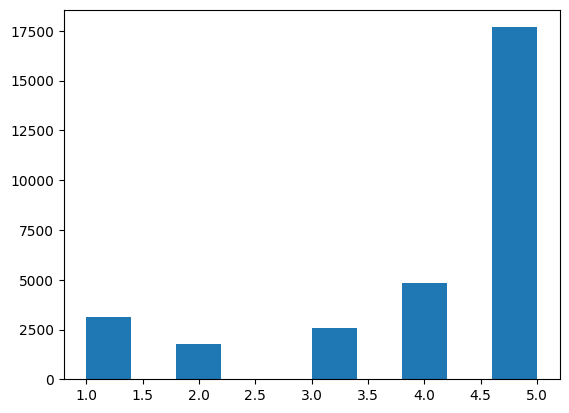

In [8]:
plt.hist(df_downsampled["Score"])
plt.show()

The imbalance is still there, but a little bit better. However, we will settle for this, since production data would likely have a similar distribution.

# Data preprocessing

Overall steps to follow:
- Remove URLS and email addresses
- Remove punctuation
- Lowercase all words
- Remove stopwords
- Lemmatize words
- Transform text to to numeric vectors

In [9]:
# Remove URLS and email addresses
df_downsampled['Text'] = df_downsampled['Text'].str.replace(r'http\S+|www.\S+|(\@\w+)', '', case=False, regex=True)

# Remove punctuation signs
df_downsampled['Text'] = df_downsampled['Text'].str.replace(r'[^\w\s]', '', regex=True)

# Remove numbers
df_downsampled['Text'] = df_downsampled['Text'].str.replace(r'\d+', '', regex=True)

# Remove <br /> tags
df_downsampled['Text'] = df_downsampled['Text'].str.replace('<br />', '')

df_downsampled['Text'] = df_downsampled['Text'].str.replace(" br ", '')

# Lowercase the text
df_downsampled['Text'] = df_downsampled['Text'].str.lower()


In [10]:
df_downsampled.head()

,Text,Score
326531,i have tried several brands of coffee for the ...,5
281964,i saw this at the local walmart and decided to...,5
518555,i have these things all over the house and thi...,4
296586,if you miss eating bread and are a low carb ea...,5
227076,i really wanted to buy these but for some unhe...,1


### Stopwords and Lemmatizing

Removing the stopwords means taking away the most common words in the english language, those that are not very significant when trying to analyze the sentiment in a sentence.

Lemmatizing means reducing each word to its "lemma", or the root of the word. For example, the lemma of "running" is "run". This is useful because it reduces the number of words that the model has to learn, and it also helps to group together words that have the same meaning.

In [11]:
# Remove stopwords
stop = nltk.corpus.stopwords.words('english')
lemmatized_text = df_downsampled['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Lemmatizing
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatized_text = lemmatized_text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

For comparison, we can take a look at an example of a review before and after preprocessing.

In [12]:
review = df_downsampled["Text"][326531]
review_preprocessed = lemmatized_text[326531]
print("Raw review: \n", review)
print("Preprocessed review: \n", review_preprocessed)


Raw review: 
 i have tried several brands of coffee for the keurig and this has excellent flavor and aroma  although i would prefer a bolder taste for decaf this more than passed the test
Preprocessed review: 
 tried several brand coffee keurig excellent flavor aroma although would prefer bolder taste decaf passed test


This shows that it is worth it to remove the stop words and lemmatizing, as it reduces the number of features by a lot and the information loss is not significant.

### Scores (target variable)


In [13]:
# Map scores to 0 and 1
# I have Decided to map 1,2,3 to 0 and 4,5 to 1
# So, now we have a binary classification problem; 0 for negative sentiment and 1 for positive
y = df_downsampled["Score"].map({1:0, 2:0, 3:0, 4:1, 5:1})

y = y.values.astype("float32")

### Tokenize the text

Tokenizing the text is basically splitting the text into words. We will use the NLTK library to tokenize the text.

In [14]:
tokenized_text = [word_tokenize(i) for i in lemmatized_text]

### Word embeddings


Here, we load a previously trained model on this particular dataset. However, there are many alternatives for different models, as well as pretrained models that can be downloaded from the internet. For example, the [Stanford NLP group](https://nlp.stanford.edu/projects/glove/) has a set of pretrained models that can be used for sentiment analysis.

In [15]:
# This model was previously trained with this same dataset.
# The model was saved in a binary file with model.save()

vector_size = 128

#model = KeyedVectors.load('model2-10k-reviews.bin')
model = KeyedVectors.load('model2-30k-reviews.bin')

In [16]:
# Assigns each word in every sentence of every review a vector of the model.

def create_sequences(tokenized_text, model, vector_size):
    sequences = []
    for seq in tokenized_text:
        seq_vectors = []
        for token in seq:
            if token in model.wv:
                seq_vectors.append(model.wv[token])
            else:
                seq_vectors.append(np.zeros((vector_size,)))
        sequences.append(seq_vectors)

    return sequences

sequences = create_sequences(tokenized_text, model, vector_size)

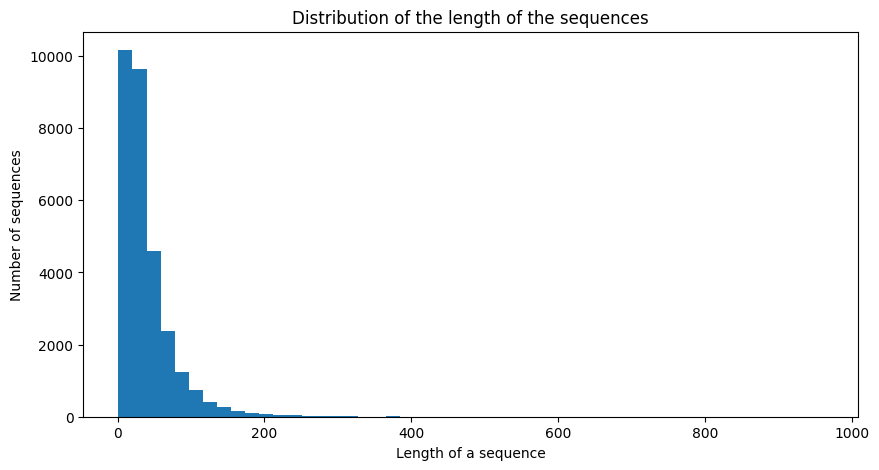

In [17]:
# Distribution of the length of the sequences
plt.figure(figsize=(10, 5))
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('Length of a sequence')
plt.ylabel('Number of sequences')
plt.title('Distribution of the length of the sequences')
plt.show()


### Padding the sequences


This step is crucial, due to the fact that LSTMs cannot handle inhomogenous data, meaning that each sequence must be of the same length. The scikit learn pad_sequences function allows us to do this. We will pad the sequences with zeros, meaning that the sequences will be added the necessary zeros at the end. We will also need to define the maximum length of the sequences, which we will set to 80 in this case, by looking at the previous graph. This means that sequences with length less than 80 will be padded with zeros, and sequences with length greater than 80 will be truncated to 80.

A higher <b>maxlen</b> will result in less information loss, though a higher sequence length, which will take longer to train. However, the information loss is not that significant, since we are truncating at the end of the review, and usually words that are the most relevant for sentiment analysis are at the beginning of the sentence.

In [18]:
sequences_padded = pad_sequences(sequences, maxlen=80, padding='post', truncating='post', dtype='float32')

In [19]:
# How many sequences have more than 80 tokens?
print("Number of sequences with more than 80 tokens: ", len([x for x in sequences if len(x) > 80]))

Number of sequences with more than 80 tokens:  3012


# Data split

I opted for this split
- 80% training
- 10% validation
- 10% testing


In [20]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [21]:
# Print shapes to check
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)



X_train shape:  (24000, 80, 128)
X_val shape:  (3000, 80, 128)
X_test shape:  (3000, 80, 128)
y_train shape:  (24000,)
y_val shape:  (3000,)
y_test shape:  (3000,)


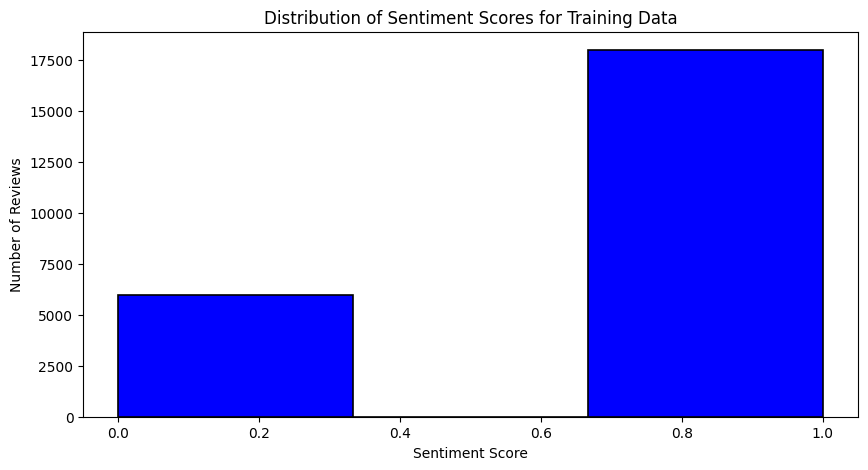

In [22]:
# Analyze distribution of sentiment scores training dataset
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=3, color='blue', edgecolor='black', linewidth=1.2)
plt.title('Distribution of Sentiment Scores for Training Data')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')
plt.show()

In [23]:
# Amount of 0s and amount of 1s in the y_train array
print(np.unique(y_train, return_counts=True))


(array([0., 1.], dtype=float32), array([ 5997, 18003]))


So, there are around 6k negative reviews and 18k positive reviews in the training set. The proportion of negative reviews is about 1/4 in the training dataset.

# Model

Here, I am using LSTM layers, but I also could have used GRU layers (Gated Recurrent Units).   
For regularization, I am using a dropout layer with 0.5 as the dropout rate.  
Since this is a binary classification problem, I am using a sigmoid activation function in the output layer, as well as a binary_crossentropy loss function.

### Class weights
Class weights are useful when handling imbalanced datasets. In this particular case, I created some weights using scikit-learn and one made "by hand", though I ended up using the no_weights dict since it resulted in better performance.

In [24]:
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(y_train), 
                                     y=y_train)
class_weights = dict(enumerate(class_weights))

class_weights2 = {0: 1.5, 1: 0.8}

no_weights = {0: 1, 1: 1}

print(class_weights)
print(class_weights2)

{0: 2.001000500250125, 1: 0.6665555740709882}
{0: 1.5, 1: 0.8}


Regarding the structure of the model, I opted for reducing the number of layers to one since the model was too complex for the data, as well as setting the units to 50.  
I also added a Masking layer so that the model "skips" the timesteps that are the result of padding the sequences so they have the same length.  
Finally, I added a Dropout layer to avoid overfitting.

In [25]:
rnn = Sequential()
#masking layer to mask the padded zeros
rnn.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
rnn.add(LSTM(50, return_sequences=False))
rnn.add(Dropout(0.5))
rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(loss='binary_crossentropy', 
            optimizer=Adam(learning_rate=0.0005), 
            metrics=['Precision', 'Recall', 'accuracy'])



2023-07-31 18:09:59.055940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 18:09:59.094413: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [26]:
H = rnn.fit(X_train, y_train, 
        epochs=10, 
        validation_data=(X_val, y_val),
        #callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        class_weight=no_weights)

Epoch 1/10


2023-07-31 18:09:59.953495: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.


750/750 [==============================] - 21s 25ms/step - loss: 0.4473 - precision: 0.8241 - recall: 0.9136 - accuracy: 0.7889 - val_loss: 0.3744 - val_precision: 0.8680 - val_recall: 0.9123 - val_accuracy: 0.8287
Epoch 2/10
750/750 [==============================] - 18s 24ms/step - loss: 0.3909 - precision: 0.8607 - recall: 0.9098 - accuracy: 0.8219 - val_loss: 0.3655 - val_precision: 0.8845 - val_recall: 0.9004 - val_accuracy: 0.8357
Epoch 3/10
750/750 [==============================] - 17s 23ms/step - loss: 0.3760 - precision: 0.8651 - recall: 0.9146 - accuracy: 0.8290 - val_loss: 0.3707 - val_precision: 0.9103 - val_recall: 0.8498 - val_accuracy: 0.8230
Epoch 4/10
750/750 [==============================] - 17s 23ms/step - loss: 0.3645 - precision: 0.8703 - recall: 0.9178 - accuracy: 0.8357 - val_loss: 0.3436 - val_precision: 0.8770 - val_recall: 0.9361 - val_accuracy: 0.8523
Epoch 5/10
750/750 [==============================] - 17s 23ms/step - loss: 0.3507 - precision: 0.8745 - re

## Predictions

In [32]:
predictions = rnn.predict(X_test)

# Round predictions
y_pred = np.zeros(len(predictions))
for i in range(len(predictions)):
    if predictions[i] > 0.65:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

# Print the precision and recall, among other metrics
print(classification_report(y_test, y_pred, digits=3))

94/94 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

         0.0      0.710     0.663     0.686       760
         1.0      0.888     0.908     0.898      2240

    accuracy                          0.846      3000
   macro avg      0.799     0.786     0.792      3000
weighted avg      0.843     0.846     0.844      3000



### Graphs

#### Loss

This graph was very useful when handling overfitting data. When the model was trained for more than 10 epochs and on a smaller subset of the dataset, the loss graph was very useful to see if the model was overfitting or not. If the train_loss was decreasing and the val_loss was increasing, then the model was overfitting. This started to show at around the 10th epoch.

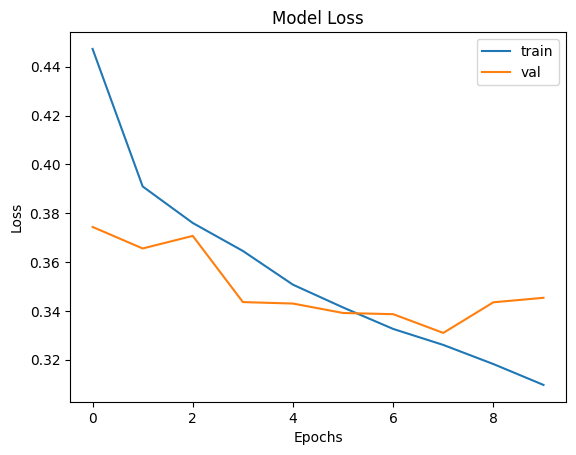

In [28]:
# plot the loss
plt.plot(H.history['loss'], label='train')
plt.plot(H.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



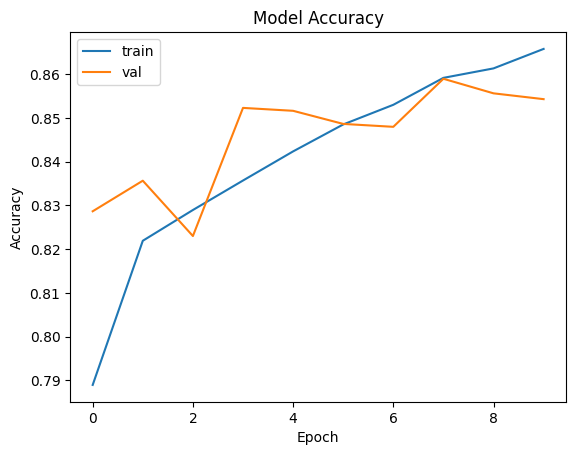

In [29]:
# Plot accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

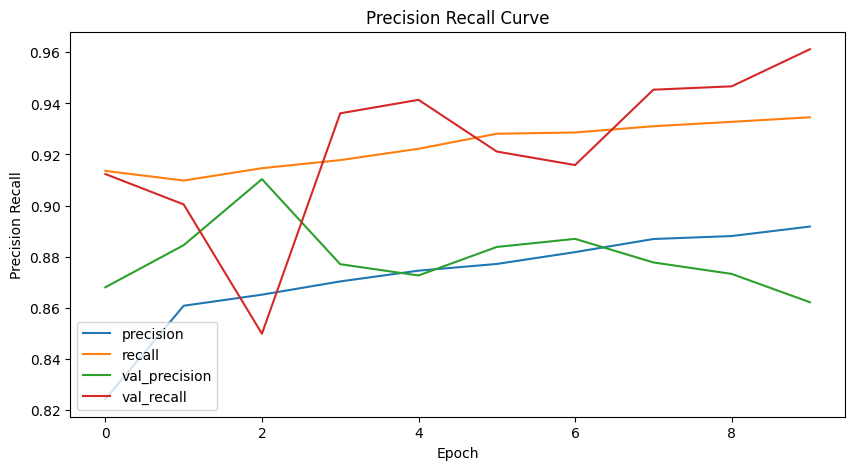

In [30]:
# Plot precision recall curve
plt.figure(figsize=(10, 5))
plt.plot(H.history['precision'], label='precision')
plt.plot(H.history['recall'], label='recall')
plt.plot(H.history['val_precision'], label='val_precision')
plt.plot(H.history['val_recall'], label='val_recall')
plt.title('Precision Recall Curve')
plt.xlabel('Epoch')
plt.ylabel('Precision Recall')
plt.legend(loc='lower left')
plt.show()